In [1]:
# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))

466
156


In [2]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [4]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_train = []
for subj in train:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_train.append(feat)
    
X_test = []
for subj in test:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_test.append(feat)
    
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

print(X_train[10:20])
print('Complete')

[[193   1   0]
 [217   1   0]
 [233   1   0]
 [176   1   0]
 [116   0   1]
 [246   0   1]
 [164   1   0]
 [167   0   1]
 [202   0   1]
 [108   0   1]]
Complete


In [5]:
import torch

train_rest_ts_t = torch.from_numpy(np.stack(train_rest_ts)).float().cuda()
test_rest_ts_t = torch.from_numpy(np.stack(test_rest_ts)).float().cuda()

print('Complete')

Complete


In [35]:
import torch.nn as nn
import torch.nn.functional as F

nHid = 200
nLat = 80
nHead = 10
nWin = 5
nRoi = 264

lu = nn.ReLU()
dp = nn.Dropout(p=0)

def makeWindows(ts, ws):
    nRoi = ts.shape[1]
    nt = ts.shape[2]
    wndws = []
    for i in range(ws):
        wndws.append(ts[:,:,i:nt-ws+i+1])
    return torch.stack(wndws, dim=3)

class Trans1(nn.Module):
    def __init__(self):
        super(Trans1, self).__init__()
        self.tok1 = nn.Linear(nRoi*nWin, nHid).cuda()
        self.tok2 = nn.Linear(nHid, nLat).cuda()
        self.att1 = nn.MultiheadAttention(nLat, nHead).cuda()
        self.att2 = nn.MultiheadAttention(nLat, nHead).cuda()
        self.att3 = nn.MultiheadAttention(nLat, nHead).cuda()
        self.att4 = nn.MultiheadAttention(nLat, nHead).cuda()
        self.att5 = nn.MultiheadAttention(nLat, nHead).cuda()
        self.fc1 = nn.Linear(nLat*5, nHid).cuda()
        self.fc2 = nn.Linear(nHid, 1).cuda()
        
    def forward(self, x):
        nB = x.shape[0]
        nt = x.shape[2]
        
        outp = torch.ones(1, nB, nLat).cuda()
        
        xw = makeWindows(x, 5)
        xw = xw.permute(0, 2, 1, 3)
        xw = xw.reshape(nB*(nt-nWin+1), -1)
        
        tok = lu(self.tok2(dp(lu(self.tok1(xw)))))
        seq = tok.reshape(nB, nt-nWin+1, nLat)
        seq = seq.permute(1, 0, 2)
        seq = torch.cat([outp, seq], dim=0)
        
        seq1, _ = self.att1(seq, seq, seq)
        seq2, _ = self.att2(seq1, seq1, seq1)
        seq3, _ = self.att3(seq2, seq2, seq2)
        seq4, _ = self.att4(seq3, seq3, seq3)
        seq5, _ = self.att5(seq4, seq4, seq4)
        
        seq = torch.cat([seq1, seq2, seq3, seq4, seq5], dim=2)
        
        x = lu(self.fc1(seq[0,:,:]))
        x = self.fc2(x)
        
        return x

t1 = Trans1()
optim = torch.optim.Adam(t1.parameters(), lr=2e-4)
print('Complete')

Complete


In [36]:
import random

running = 0
nEpoch = 2000
pPeriod = 50
nB = 10
N = train_rest_ts_t.shape[0]

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nB).float().cuda()
    for i in range(nB):
        idx = random.randint(0,N-1)
        batch.append(train_rest_ts_t[idx])
        truth[i] = X_train[idx, 0]
    batch = torch.stack(batch)
    optim.zero_grad()
    pred = t1(batch).flatten()
    loss = torch.sum((pred-truth)**2)
    loss.backward()
    running += loss.detach().cpu()
    optim.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            if epoch % pPeriod != 0:
                running /= epoch % pPeriod
            else:
                running /= pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, ((running/nB)**0.5)/12))
        running = 0

print('Finished training')

epoch 0 loss=15.497123
epoch 50 loss=13.306441
epoch 100 loss=6.073990
epoch 150 loss=5.439912
epoch 200 loss=5.128639
epoch 250 loss=4.895822
epoch 300 loss=4.664396
epoch 350 loss=4.274713
epoch 400 loss=3.853077
epoch 450 loss=3.522640
epoch 500 loss=3.024011
epoch 550 loss=2.839109
epoch 600 loss=2.530669
epoch 650 loss=2.292534
epoch 700 loss=1.959334
epoch 750 loss=1.478554
epoch 800 loss=1.513268
epoch 850 loss=1.436836
epoch 900 loss=1.128956
epoch 950 loss=0.978845
epoch 1000 loss=0.973593
epoch 1050 loss=0.748468
epoch 1100 loss=0.749330
epoch 1150 loss=0.698425
epoch 1200 loss=0.689508
epoch 1250 loss=0.799689
epoch 1300 loss=0.681944
epoch 1350 loss=0.700543
epoch 1400 loss=0.549248
epoch 1450 loss=0.657863
epoch 1500 loss=0.473918
epoch 1550 loss=0.570013
epoch 1600 loss=0.472540
epoch 1650 loss=0.490343
epoch 1700 loss=0.378081
epoch 1750 loss=0.434780
epoch 1800 loss=0.357589
epoch 1850 loss=0.347688
epoch 1900 loss=0.384367
epoch 1950 loss=0.296159
epoch 1999 loss=0.556

[[1.         0.13833417]
 [0.13833417 1.        ]]
3.49557788091225
2.7654915671063285


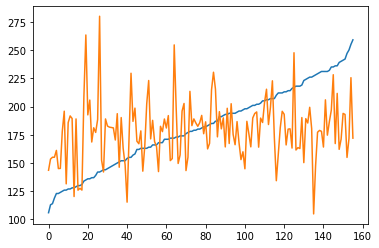

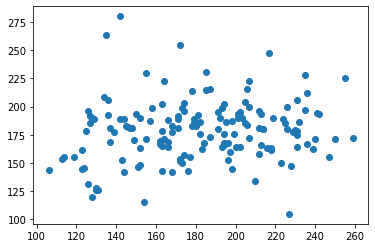

In [40]:
import matplotlib.pyplot as plt

test = test_rest_ts_t
test_labels = X_test

preds = []
for i in range(int(test.shape[0]/10+1)*10):
    i0 = i*10
    i1 = (i+1)*10
    if i0 >= test.shape[0]:
        break
    if i1 > test.shape[0]:
        i1 = test.shape[0]
    preds.append(t1(test[i0:i1,:,:]).detach().cpu().numpy().flatten())
predY = np.concatenate(preds)

idcs = np.argsort(test_labels[:,0])
yPred = predY[idcs]
y = test_labels[:,0][idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()